In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data loading

In [30]:
import random

MODERN=1
ANCIENT=0

def get_dna_sequences(f):
  dnas=f.readlines()[1::4]
  dnas=list(map(lambda x: x.strip(), dnas))
  return dnas

with open("/content/drive/MyDrive/license2thrill/Data/Ancient/C132_1.fastq", "r") as f:
  ancient1=get_dna_sequences(f)

with open("/content/drive/MyDrive/license2thrill/Data/Ancient/C132_2.fastq", "r") as f:
  ancient2=get_dna_sequences(f)

with open("/content/drive/MyDrive/license2thrill/Data/Modern/T1_1.fastq", "r") as f:
  modern1=get_dna_sequences(f)

sequences = list(map(lambda x:(x,1), modern1)) + list(map(lambda x:(x,0), ancient1)) + list(map(lambda x:(x,0), ancient2))

random.shuffle(sequences)

sequences[:5]


[('CCTACGGGTGGCAGCAGTAGGGAATTTTCGGCAATGGGGGGAACCCTGACCGAGCAACGCCGCGTGAGTGAAGACGGCCTTCGGGTTGTAAAGCTCTGTTGTAAGAAAAGATAAACTAGGAGAGGATCTTAGTCAGACATTATCTTACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTATGTCACGAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCAGGGCTCAACTCTGTATTGCGTTGGAAACTGTA',
  1),
 ('CCTACGGGTGGCAGCAGTGGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGCCGCGTGAGCGATGAAGGTCTTCGGATCGTAAAGCTCTGTCCTAGGGGAAGATAGTGACGGTACCTTAGGAGGAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAACACGTAGGGGGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGTGCGTAGGCGGCCGTGCAAGTCAGATGTGAAAGATCACGGCTTAACGGTGGTAAGCATGTGAAACTGTGAGGCGTGAGTGCAGGAGAGG',
  0),
 ('CCTACGGGTGGCAGCAGTGGGGAATATTGGACAATGGACCAAGAGTCTGATCCAGCAATTCTGTGTGCCCGATGAAGTTTTTCGGAATGTAAAGTGCTTTCAGTTGGGAAGAAAGAAATGACGGTACCAACAGAAGAAGTGACGGCTAAATACGTGCCAGCAGCCGCGGTAATACGTATGTCACGAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCAGGTCTCAACTCTGTATTGCGTTGGAAACTGTATAACTAGAGTACTTGG',
  1),
 ('CCTACGGGAGGCAGCAGTGAGGAATATTGGTCAATGGGCGAAAGCCTGAACCAGCCAA

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

# Convert sequences to k-mer frequency (k=2)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))
sequences_vectorized = vectorizer.fit_transform([x[0] for x in sequences]).toarray()

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(sequences_vectorized)

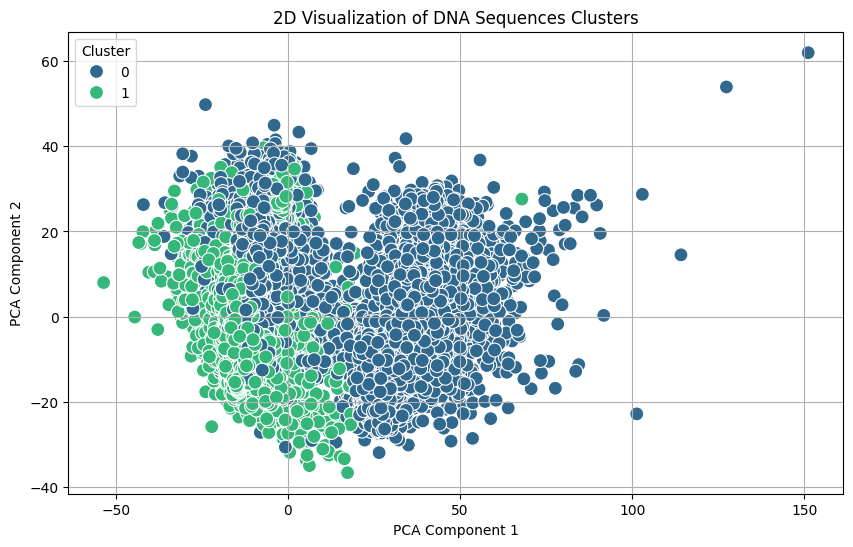

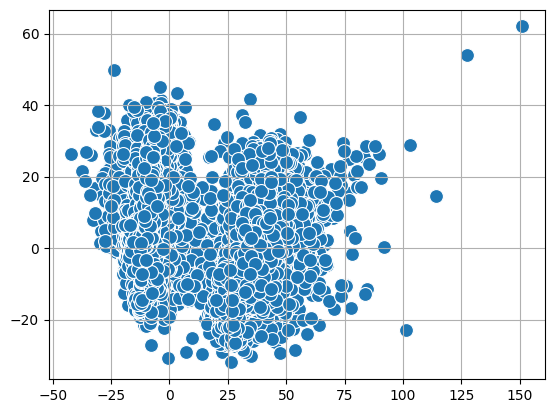

In [39]:
import seaborn as sns
import numpy
# # Dimensionality reduction using t-SNE
# tsne = TSNE(n_components=2, random_state=0)
# X_reduced = tsne.fit_transform(X)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=[label for _,label in sequences], palette='viridis', s=100)
plt.title('2D Visualization of DNA Sequences Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

x_red_modern=[]
for i in range(len(sequences)):
  _, label = sequences[i]
  if label==ANCIENT:
    x_red_modern.append(X_reduced[i])


x_red_modern=np.array(x_red_modern)
sns.scatterplot(x=x_red_modern[:, 0], y=x_red_modern[:, 1], s=100)
plt.grid()
plt.show()

In [6]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU is available and being used.")
else:
  device = torch.device("cpu")
  print("GPU is not available, using CPU instead.")

GPU is available and being used.


In [48]:
import torch
import torch.nn as nn

dna_mapper={
    'A':0,
    'T':1,
    'C':2,
    'G':3
}

class DNATransformer(nn.Module):
  def __init__(self, d_model):
    super().__init__()
    self.token_embedding_table = nn.Embedding(4, d_model) # vocab size, embedding size
    encoder_layer = torch.nn.TransformerEncoderLayer(
        d_model=d_model,
        nhead=4,
        dim_feedforward=512
    )
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
    self.output_layer = nn.Linear(in_features=d_model, out_features=2)

  def forward(self, src):
    src = self.token_embedding_table(src)
    output = self.transformer_encoder(src)
    output = self.output_layer(output)
    return output[:, -1, :]

#transformer = DNATransformer(512).to(device)
transformer = DNATransformer(16).to(device)
#one_dna = torch.stack([torch.Tensor([ dna_mapper[x] for x in sequences[0]])])
#one_dna = one_dna.to(torch.int)
#one_dna = one_dna.to(device)
#print(len(one_dna))
#transformer(one_dna).shape

In [49]:
total_params = sum(p.numel() for p in transformer.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 54290


In [8]:
dnas=torch.stack(
    [torch.Tensor([dna_mapper[x] for x in dna]) for dna,_ in sequences if len(dna)==301]
)
dnas=dnas.to(torch.int)
dnas=dnas.to(device)

targets = torch.Tensor([ [0,1] if label else [1,0] for dna,label in sequences if len(dna)==301])
targets = targets.to(device)
targets.shape

torch.Size([210177, 2])

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class DNADataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return sequence, label

# Assuming you have your DNA sequences in 'dnas' and labels in 'targets'
dataset = DNADataset(dnas, targets)

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size=64

# Create dataloaders for each split
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# slicing for now
if False:
  dnas=dnas[:10, :]
  targets=targets[:10]
  dnas.shape
  #targets.shape

  print(dnas.shape)
  transformer(dnas).shape


  #targets=torch.tensor([0,1,0,1,1,0,0,0,1,1])

In [59]:
train_loss_history=[]
val_loss_history=[]
accuracy_history=[]

In [ ]:
import torch.optim as optim
import torch.nn.functional as F


transformer=transformer.to(device)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(transformer.parameters(), lr=0.001)  # Optimizer


no_epochs = 10
for epoch in range(no_epochs):

    train_total_loss = 0

    val_total_loss = 0

    transformer.eval()
    with torch.no_grad():
      total_accuracy=0
      for x_batch, y_batch in val_dataloader:
        probs = F.softmax(transformer(x_batch), dim=-1)
        loss = criterion(probs, y_batch)
        val_total_loss+=loss
        probs = F.softmax(transformer(x_batch), dim=-1)

        # accuracy on validation
        predicted = torch.argmax(probs, dim=-1)
        target = torch.argmax(y_batch, dim=-1)
        matching_cnt = (predicted==target).sum().item()
        total_accuracy+=matching_cnt
      total_accuracy/=len(val_dataloader)*val_dataloader.batch_size
      accuracy_history.append(total_accuracy)
      print(f"Accuracy:{total_accuracy}")

    if True:
      transformer.train()  # Set the model to training mode
      for x_batch, y_batch in train_dataloader:
        optimizer.zero_grad()  # Zero the gradients
        # Forward pass
        #x_batch = x_batch.to(device)
        probs = F.softmax(transformer(x_batch), dim=-1)
        # Compute loss
        loss = criterion(probs, y_batch)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_total_loss+=loss

    val_loss_history.append((train_total_loss/len(train_dataloader)).item())
    train_loss_history.append((val_total_loss/len(val_dataloader)).item())




Accuracy:0.6835521308980214
Accuracy:0.6835521308980214
Accuracy:0.6835521308980214
Accuracy:0.6835521308980214


[0.6166322231292725, 0.6167382597923279, 0.616502583026886]


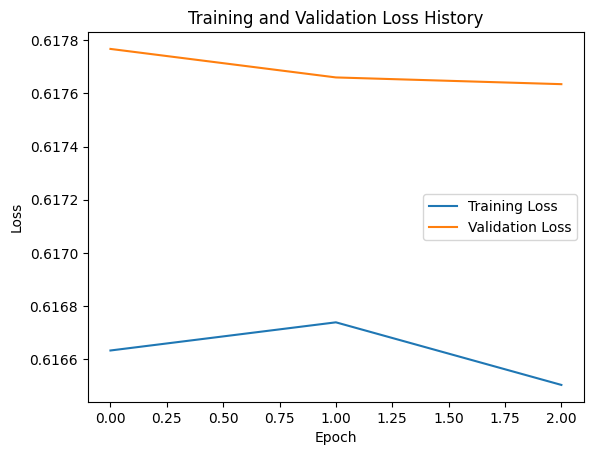

In [65]:
import matplotlib.pyplot as plt

print(train_loss_history)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.show()